In [1]:
import pandas as pd
import cv2
import numpy as np
from keras.utils import np_utils
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import preprocess_input

In [2]:
physical_devices = tensorflow.config.experimental.list_physical_devices('GPU')
tensorflow.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
main_folder = "C:/Users/ahmet/Calismalarim/opencv"
image_folder = main_folder + "/img_align_celeba/img_align_celeba/"

In [4]:
example_picture = "C:/Users/ahmet/Calismalarim/opencv/img_align_celeba/img_align_celeba/000103.jpg"

img_width = 178
img_height = 218

In [5]:
df_ = pd.read_csv(main_folder + '/list_attr_celeba.csv')
df = df_.copy()
df.set_index('image_id', inplace=True)
df.replace(to_replace=-1, value=0, inplace=True)
df.shape

(202599, 40)

In [6]:
for i, j in enumerate(df.columns):
    print(i, j)

0 5_o_Clock_Shadow
1 Arched_Eyebrows
2 Attractive
3 Bags_Under_Eyes
4 Bald
5 Bangs
6 Big_Lips
7 Big_Nose
8 Black_Hair
9 Blond_Hair
10 Blurry
11 Brown_Hair
12 Bushy_Eyebrows
13 Chubby
14 Double_Chin
15 Eyeglasses
16 Goatee
17 Gray_Hair
18 Heavy_Makeup
19 High_Cheekbones
20 Male
21 Mouth_Slightly_Open
22 Mustache
23 Narrow_Eyes
24 No_Beard
25 Oval_Face
26 Pale_Skin
27 Pointy_Nose
28 Receding_Hairline
29 Rosy_Cheeks
30 Sideburns
31 Smiling
32 Straight_Hair
33 Wavy_Hair
34 Wearing_Earrings
35 Wearing_Hat
36 Wearing_Lipstick
37 Wearing_Necklace
38 Wearing_Necktie
39 Young


In [7]:
df.rename(columns={"Male": "Gender"}, inplace=True)

Attractive    1
Gender        0
Young         1
Name: 000103.jpg, dtype: int64

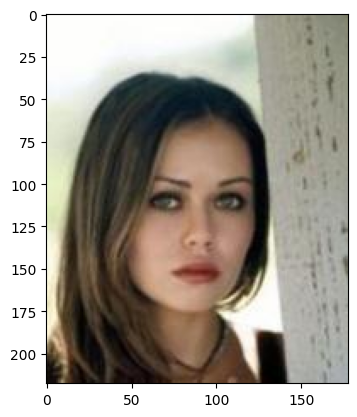

In [8]:
img = load_img(example_picture)
plt.grid(False)
plt.imshow(img)

df.loc[example_picture.split('/')[-1]][['Attractive','Gender','Young']]

<Axes: title={'center': 'Female and Male'}, xlabel='count', ylabel='Gender'>

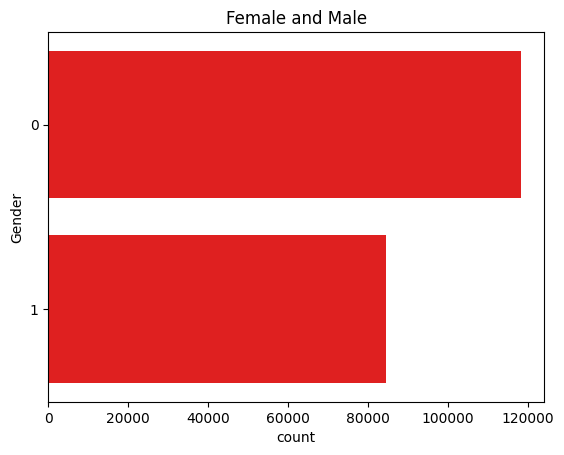

In [9]:
plt.title("Female and Male")
sns.countplot(y="Gender", data=df, color="r")

In [10]:
df_part = pd.read_csv(main_folder + "/list_eval_partition.csv")
df_part.head()

,image_id,partition
0,000001.jpg,0
1,000002.jpg,0
2,000003.jpg,0
3,000004.jpg,0
4,000005.jpg,0


In [11]:
df_part.partition.value_counts()

# 0 -> train
# 1 -> validation
# 2 -> test

partition
0    162770
2     19962
1     19867
Name: count, dtype: int64

In [12]:
df_part.set_index("image_id", inplace=True)
df_part = df_part.join(df.Gender, how='inner')
df_part.head()

,partition,Gender
image_id,,
000001.jpg,0,0
000002.jpg,0,0
000003.jpg,0,1
000004.jpg,0,0
000005.jpg,0,0


In [13]:
def load_reshape_img(fname):
    img = load_img(fname)
    x = img_to_array(img)/255.
    x = x.reshape((1,) + x.shape)

    return x


def generate_df(partition, attr, num_samples):
    
    df_ = df_part[(df_part['partition'] == partition) 
                           & (df_part[attr] == 0)].sample(int(num_samples/2))
    df_ = pd.concat([df_,
                      df_part[(df_part['partition'] == partition) 
                                  & (df_part[attr] == 1)].sample(int(num_samples/2))])

    if partition != 2:
        x_ = np.array([load_reshape_img(image_folder + fname) for fname in df_.index])
        x_ = x_.reshape(x_.shape[0], 218, 178, 3)
        y_ = np_utils.to_categorical(df_[attr],2)
    else:
        x_ = []
        y_ = []

        for index, target in df_.iterrows():
            im = cv2.imread(image_folder + index)
            im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (img_width, img_height)).astype(np.float32) / 255.0
            im = np.expand_dims(im, axis =0)
            x_.append(im)
            y_.append(target[attr])

    return x_, y_

In [14]:
datagen = ImageDataGenerator(
    rotation_range=20,      
    width_shift_range=0.2,  
    height_shift_range=0.2,
    shear_range=0.2,       
    zoom_range=0.2,      
    horizontal_flip=True,  
)

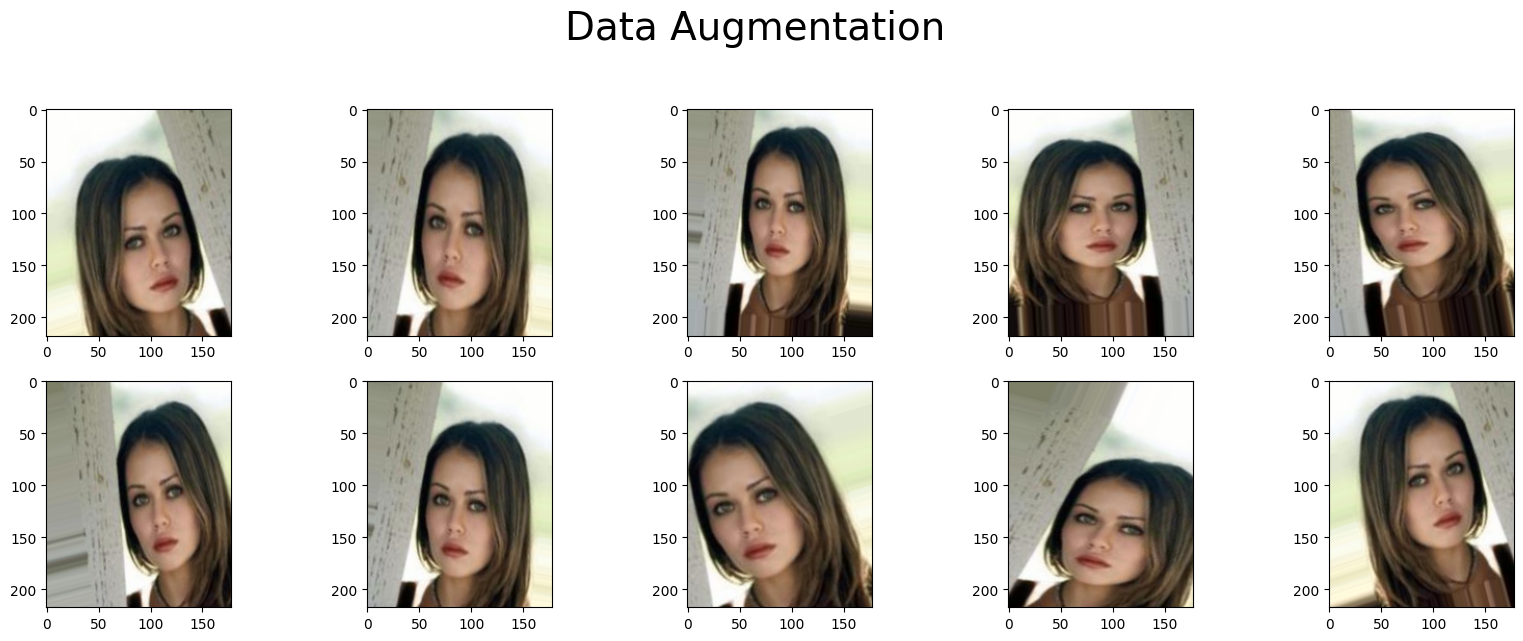

In [15]:
img = load_img(example_picture)
x = img_to_array(img)/255.
x = x.reshape((1,) + x.shape)

plt.figure(figsize=(20,10))
plt.suptitle('Data Augmentation', fontsize=28)

i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.subplot(3, 5, i+1)
    plt.grid(False)
    plt.imshow( batch.reshape(218, 178, 3))
    
    if i == 9:
        break
    i += 1

In [16]:
training_samples = 20000
x_train, y_train = generate_df(0, 'Gender', training_samples)

train_datagen =  ImageDataGenerator(
  preprocessing_function=preprocess_input,
  rotation_range=20,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True,
)

train_datagen.fit(x_train)

train_generator = train_datagen.flow(
x_train, y_train,
batch_size=32,
)

In [17]:
validation_samples=4000
x_valid, y_valid = generate_df(1, 'Gender', validation_samples)

valid_datagen =  ImageDataGenerator(
  preprocessing_function=preprocess_input,
  rotation_range=20,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True,
)

valid_datagen.fit(x_valid)

valid_generator = valid_datagen.flow(
x_valid, y_valid,
batch_size=32,
)

In [18]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

inception_model = InceptionV3(weights='imagenet', include_top=False, input_shape = (img_height, img_width, 3))
print("number of layers:", len(inception_model.layers))

number of layers: 311


In [19]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

x = inception_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)

custom_model = Model(inputs=inception_model.input, outputs=predictions)

In [20]:
from tensorflow.keras.optimizers import SGD

for layer in custom_model.layers[:52]:
    layer.trainable = False

custom_model.compile(optimizer=SGD(learning_rate=0.0005, momentum=0.8)
                    , loss='categorical_crossentropy'
                    , metrics=['accuracy'])

In [21]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='loss', patience=1)

In [ ]:
hist = custom_model.fit(train_generator, validation_data=(x_valid, y_valid), 
                 steps_per_epoch=training_samples/20, epochs=20, verbose=1, callbacks = [early_stopping])

Epoch 1/20
 327/1000 [========>.....................] - ETA: 26:23 - loss: 0.3851 - accuracy: 0.8312

In [ ]:
def visualize_training(history, lw = 3):
    plt.figure(figsize=(10,10))
    plt.subplot(2,1,1)
    plt.plot(history.history['accuracy'], label = 'training', marker = '*', linewidth = lw)
    plt.plot(history.history['val_accuracy'], label = 'validation', marker = 'o', linewidth = lw)
    plt.title('Accuracy Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend(fontsize = 'x-large')
    
visualize_training(hist)

In [ ]:
from sklearn.metrics import f1_score

test_samples = 4000
x_test, y_test = generate_df(2, 'Gender', test_samples)
model_predictions = [np.argmax(custom_model.predict(feature)) for feature in x_test ]

test_accuracy = 100 * np.sum(np.array(model_predictions)==y_test) / len(model_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)
print('f1_score:', f1_score(y_test, model_predictions))

In [ ]:
gender_target = {0: 'Female'
                , 1: 'Male'}

def img_to_display(filename):
 
    i = Image.open(filename)
    i.thumbnail((200, 200), Image.LANCZOS)
    
    with BytesIO() as buffer:
        i.save(buffer, 'jpeg')
        return base64.b64encode(buffer.getvalue()).decode()
    

def display_result(filename, prediction, target):
    gender = 'Male'
        
    if prediction[1] <= 0.5:
        gender = 'Female'
            
    display_html = '''
    <div style="overflow: auto;  border: 2px solid #D8D8D8;
        padding: 5px; width: 480px;" >
        <img src="data:image/jpeg;base64,{}" style="float: left;" width="200" height="200">
        <div style="padding: 10px 0px 0px 20px; overflow: auto;">
            <h3 style="margin-left: 50px; margin-top: 2px;">Prediction: {}</h3>
            <p style="margin-left: 50px; margin-top: -6px; font-size: 12px">{} probability</p>
            <p style="margin-left: 50px; margin-top: -16px; font-size: 12px">Real gender: {}</p>
        </div>
    </div>
    '''.format(img_to_display(filename)
               , gender
               , "{0:.2f}%".format(round(max(prediction)*100,2))
               , gender_target[target]
               , filename.split('/')[-1]
               )

    display(HTML(display_html))

In [ ]:
def gender_prediction(filename):
    im = cv2.imread(filename)
    im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (178, 218)).astype(np.float32) / 255.0
    im = np.expand_dims(im, axis=0)
    
    result = custom_model.predict(im)
    prediction = np.argmax(result)
    
    return result

df_to_test = df_part[df_part['partition'] == 2].sample(8)

for index, target in df_to_test.iterrows():
    result = gender_prediction(image_folder + index)
    display_result(image_folder + index, result[0], target['Gender'])
